# Data extraction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("../data/creditcard.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Preprocessing

## Train/Test split

In [4]:
X = df.drop("Class", axis=1)
y = df["Class"]

In [5]:
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=11, test_size=0.2, stratify=y)

# XGboost

## class weight computation

In [6]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)

{np.int64(0): np.float64(0.5008661206149896), np.int64(1): np.float64(289.14340101522845)}


In [7]:
n_neg = sum(y_train == 0)
n_pos = sum(y_train == 1)
scale_pos_weight = n_neg / n_pos
print(scale_pos_weight)

577.2868020304569


In [8]:
# xgboost classifier model
xgb = XGBClassifier(
    objective= "binary:logistic",
    eval_metric= "logloss",
    random_state=11
)
# paramethers
params = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.1, 0.01, 0.03],
    "scale_pos_weight": [10, 25, 50]
}
# random search implemented on paramethers
random_search = RandomizedSearchCV(
    estimator= xgb,
    param_distributions= params,
    n_iter= 25,
    scoring= 'f1',
    cv = 5,
    verbose = 2,
    n_jobs= -1
)


In [9]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'learning_rate': [0.1, 0.01, ...], 'n_estimators': [100, 200, ...], 'scale_pos_weight': [10, 25, ...]}"
,n_iter,25
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [10]:
print("Best parameters found by GridSearchCV:")
print(random_search.best_params_)

Best parameters found by GridSearchCV:
{'scale_pos_weight': 25, 'n_estimators': 500, 'learning_rate': 0.1}


In [11]:
best_model = random_search.best_estimator_
print(best_model)
y_pred = best_model.predict(X_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)


# Evaluation

In [12]:
print("\nClassification Report for the Best Model:")
print(classification_report(y_test, y_pred))


Classification Report for the Best Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.85      0.89        98

    accuracy                           1.00     56962
   macro avg       0.97      0.92      0.95     56962
weighted avg       1.00      1.00      1.00     56962



In [13]:
y_prob = best_model.predict_proba(X_test)[:,1]
fpr, tpr, threshold= roc_curve(y_test, y_prob)

auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC:", auc)

ROC-AUC: 0.9803966571152941


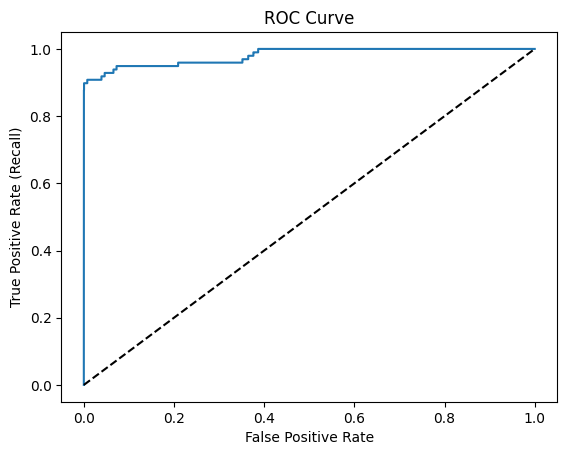

In [14]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.show()